In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import utils
pd.set_option('chained_assignment',None)
import sliding_cv
import helpers
from multiprocessing import Pool
import datetime
import statistics
import importlib
#TODO:
#1. Go Through the flow
#2. Edit functionsma
#3. Simply to reading.

In [2]:
sys.path.append('../generic_tools/')

In [ ]:
total_all_with_zero = pd.read_pickle('./data/data_store/total_all_open_to_open.pkl') # t+2 dataframe
price_df = pd.read_pickle('./data/data_store/price_df_open_to_open.pkl')

In [1]:
all_features = pd.read_pickle('./data/data_store/all_features_t2.pkl')

In [2]:
all_features

['price_to_bv1',
 'market_capsales1',
 'gross_profit_margin1',
 'operating_profit_margin1',
 'net_profit_margin1',
 'net_sales1',
 'pbidt1',
 'other_income1',
 'ebitda1',
 'ebit1',
 'reported_profit_after_tax1',
 'total_expenditure1',
 'tax1',
 'ebt1',
 'price_to_bv2',
 'market_capsales2',
 'gross_profit_margin2',
 'operating_profit_margin2',
 'net_profit_margin2',
 'net_sales2',
 'pbidt2',
 'other_income2',
 'ebitda2',
 'ebit2',
 'reported_profit_after_tax2',
 'total_expenditure2',
 'tax2',
 'ebt2',
 'price_to_bv4',
 'market_capsales4',
 'gross_profit_margin4',
 'operating_profit_margin4',
 'net_profit_margin4',
 'net_sales4',
 'pbidt4',
 'other_income4',
 'ebitda4',
 'ebit4',
 'reported_profit_after_tax4',
 'total_expenditure4',
 'tax4',
 'ebt4',
 'price_to_bv_dd1',
 'market_capsales_dd1',
 'gross_profit_margin_dd1',
 'operating_profit_margin_dd1',
 'net_profit_margin_dd1',
 'net_sales_dd1',
 'pbidt_dd1',
 'other_income_dd1',
 'ebitda_dd1',
 'ebit_dd1',
 'reported_profit_after_tax_dd

In [122]:
price_df.to_pickle('./data/data_store/price_df_close_to_close.pkl')

In [4]:
all_features_with_momentum = all_features + ['price_mom_3','price_mom_7','price_mom_15','price_mom_30']

In [5]:
## remove the earnings announcement date and consider t+1 as the 'date column'
total_all_with_zero.drop(columns = ['date_x'] , inplace=True)
total_all_with_zero.rename(columns={'date_y':'date'} , inplace=True)

In [6]:
ret_cols = [i for i in total_all_with_zero.columns if i.startswith('ret_')]
exit_date_cols = [i for i in total_all_with_zero.columns if i.startswith('exit_date')]

total_all_with_zero.drop(columns=ret_cols+exit_date_cols,inplace=True)

total_all_with_zero.drop(columns=['open_price','close_price','weekday'],inplace=True)

total_all_with_zero.dropna(subset=['date'],inplace=True)

In [7]:
import create_target_classes

In [123]:
d1_features

['price_to_bv1',
 'market_capsales1',
 'gross_profit_margin1',
 'operating_profit_margin1',
 'net_profit_margin1',
 'net_sales1',
 'pbidt1',
 'other_income1',
 'ebitda1',
 'ebit1',
 'reported_profit_after_tax1',
 'total_expenditure1',
 'tax1',
 'ebt1']

In [8]:
#total_all_with_zero = total_all_with_zero[total_all_with_zero.nse_sym]


def sliding_model_returns(param_dict):
    
    ## for the multiprocessing pool process
    
    total_all = param_dict['total_all'] #1
    train_period = param_dict['train_period']
    test_period = param_dict['test_period']
    calc_train_stats = param_dict['calc_train_stats']
    price_df = param_dict['price_df'] #5 
    fl_ = param_dict['fl_']
    n_comps = param_dict['n_comps']
    n_features = param_dict['n_features']
    gen_points = param_dict['gen_points']
    name = param_dict['name']  #10
    model = param_dict['model']
    synthetic_use = param_dict['synthetic_use']
    generate_points = param_dict['generate_points']  # just to check if its improving the hit_rate
    disc2 = param_dict['disc2']
    threshold = param_dict['threshold']  #15
    time_col = param_dict['time_col']
    sl_rules = param_dict['sl_rules']
    train_store_path = param_dict['train_store_path']
    test_store_path = param_dict['test_store_path']
    train_store_name = param_dict['train_store_name'] #20
    test_store_name = param_dict['test_store_name']  #21
    
    
    
    total = total_all.copy(deep=True)
    
    total['date'] = pd.to_datetime(total['date'])
    
    if disc2:
        total['target'] = utils.disc_2_using_thres(total[name].values, threshold=threshold) 
        signals_list = [1]
    else:
#         total['target'] = utils.disc_3_using_thres(total[name].values, threshold=threshold)

#         for saving the out_df

#         out_df = create_target_classes.make_target_classes(price_df.iloc[:,:4]
#                                 ,col='open_price',threshold=threshold,
#                                sq_off_days=name,company_col='nse_symbol', date_col = 'date')
#         out_df.rename(columns={'date':'date_new'} , inplace=True)
#         out_df.to_pickle('./data/data_store/out_df.pkl')
#         print('out_df saved')

        #read out_df
    
        out_df = pd.read_pickle('./data/data_store/out_df.pkl')
        
        total = pd.merge_asof(total.sort_values('date'),out_df.sort_values('date_new'),
                                   left_on='date',right_on='date_new' , by='nse_symbol',
                    direction='forward')
        total.to_excel('./reports/total.xlsx' , index=False)
        print('total df saved')
#         print(total.columns)
        total['target'] = total['target_class']
        signals_list = [1,-1]
    
#     print(total.shape , 'before dropping the na target and na exit_date')
    total = total.dropna(subset=['target','exit_date'] )  # dropping rows where target is np.nan
#     print(total.shape , 'after dropping the na target')
    total.to_excel('./reports/scaled_total.xlsx',index=False)
    print('scaled total saved')
    sld_inds = sliding_cv.sliding_splits(total.date , train_period,test_period)
    
    train_all_list = []
    test_all_list = []
    
    feature_importances_list = []
    
    on1_list = []
    on2_list = []
    
    for tp in sld_inds:
        train = total.iloc[tp[0]]
        test = total.iloc[tp[1]]
        print(train.shape , test.shape)
#             print('train_test enter')
        train_all,test_all, feat_imp,on1,on2  =  helpers.train_test_returns(train,test,calc_train_stats
                ,fl_,price_df, n_comps, n_features,gen_points, name, model,synthetic_use,generate_points,
                signals_list, threshold,disc2,time_col, sl_rules)
#             print('train_test  complete' )
        feature_importances_list.append(feat_imp)
        test_all_list.append(test_all)
        train_all_list.append(train_all)
        on1_list.append(on1)
        on2_list.append(on2)
   

    return train_all_list , test_all_list , feature_importances_list,on1_list , on2_list



def para_main(sample_) :



    model_here = XGBClassifier(max_depth=sample_['max_depth'], learning_rate=sample_['learning_rate'], 
                               n_estimators=sample_['n_estimators'], silent=True, 
                               objective='binary:logistic', booster='gbtree',
                                n_jobs=20, nthread=None, gamma=sample_['gamma'], min_child_weight=1,
                               max_delta_step=0,subsample=1, 
                               colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, 
                                reg_lambda=1, clas= sample_['scale_pos_weight'] , 
                               base_score=0.5, random_state=0, 
                               seed=None,missing=np.nan)

    param_dict_default = {'total_all':total_all_with_zero,
        'train_period':1000 ,
        'test_period':300,
        'calc_train_stats':False  ,
        'price_df': price_df, #5
        'fl_': all_features,
        'n_comps': -1 ,
        'n_features': -1, 
        'gen_points':5000,
        'name': 30,  #10
        'model' : model_here,
        'synthetic_use':False,
        'generate_points':False,
        'disc2': True, 
        'threshold' : 1,
        'time_col' : 'date', #16
        'sl_rules' : {"target": sample_['target_threshold'], "stop_loss": sample_['threshold'],'mode':'xyz'},
        'train_store_path' : './reports/train_multi/',
        'test_store_path' : './reports/test_multi/' ,
        'train_store_name': 'traincheck'  ,  # works if as default param
        'test_store_name':  'test_check' } #21

    #modify param_dict_default into sliding_model_returns
    for i in param_dict_default:
        if i in sample_:
            param_dict_default[i] = sample_[i]



    train_all_list,test_all_list,feature_importances_list,on1_list , on2_list = \
    sliding_model_returns(param_dict=param_dict_default)

    print('complete')
    
    return train_all_list,test_all_list,feature_importances_list , on1_list , on2_list
        


# ]:



total_all_with_zero.nse_symbol.nunique()
new_price_df = price_df[price_df.nse_symbol.isin(total_all_with_zero.nse_symbol.unique())]

In [9]:
features_10 = ['price_to_bv1', 'net_sales2', 'price_to_bv4', 'other_income4', 
               'net_sales_dd1', 'other_income_dd1', 'price_mom_3', 'price_mom_7', 
               'price_mom_15', 'price_mom_30']

In [10]:
features_30 = ['price_to_bv1', 'market_capsales1', 'gross_profit_margin1', 
               'net_sales1', 'other_income1', 'total_expenditure1', 'tax1', 
               'price_to_bv2', 'market_capsales2', 'net_sales2', 'other_income2',
               'ebitda2', 'reported_profit_after_tax2', 'total_expenditure2', 'price_to_bv4', 
               'market_capsales4', 'ebitda4', 'reported_profit_after_tax4', 'total_expenditure4', 
               'tax4', 'ebt4', 'net_sales_dd1', 'ebitda_dd1', 'net_profit_margin_dd2', 'other_income_dd2',
               'reported_profit_after_tax_dd2', 'market_capsales_dd4', 'reported_profit_after_tax_dd4', 
               'total_expenditure_dd4', 'tax_dd4']

In [11]:
dd_features = [i for i in all_features_with_momentum if str(i[-3:]) in ['dd1','dd2','dd3','dd4'] ]

non_dd_features = [i for i in all_features_with_momentum if i not in dd_features]

all_cols = total_all_with_zero.columns

raw_features = [i for i in all_cols if i not in all_features_with_momentum]

raw_features.remove('nse_symbol'); raw_features.remove('date');raw_features.remove('reference_date')

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
features = raw_features+non_dd_features

In [14]:
# #scale per company
# for i in total_all_with_zero.nse_symbol.unique():
#     scaler = MinMaxScaler(feature_range=(-1,1))
#     total_all_with_zero.loc[total_all_with_zero.nse_symbol==i , all_features+raw_features] =  \
#     scaler.fit_transform(total_all_with_zero.loc[total_all_with_zero.nse_symbol==i , all_features+raw_features])


In [15]:
d1_features = [i for i in total_all_with_zero.columns if i.endswith('1')]

In [16]:
d1_features = [i for i in d1_features if not i.endswith('dd1')]

In [17]:
importlib.reload(helpers)

<module 'helpers' from '/home/nithish/workspace/python/fund_delta_model/helpers.py'>

In [18]:
total_all_with_zero.head()

nse_symbol  price_to_bv  market_capsales  gross_profit_margin  \
0       INFY         7.01             7.02             0.342950   
1    DCBBANK         1.93             1.71                  NaN   
2       ZEEL         2.83             4.02             0.299874   
3     RPOWER         2.69            71.07             0.658602   
4        NCC         1.25             0.49             0.115714   

   operating_profit_margin  net_profit_margin  net_sales    pbidt  \
0                 0.342950           0.342950    7106.00  2437.00   
1                      NaN           0.080374     140.22   102.18   
2                 0.290442           0.297001     824.88   247.36   
3                 0.627801           0.385929     251.29   165.50   
4                 0.093381           0.074469    1564.55   181.04   

   other_income   ebitda      ...       reported_profit_after_tax_dd4  \
0        290.00  2147.00      ...                           58.330935   
1         26.01    76.17      ...                         1114.370797   
2         23.23   224.13      ...                          -27.907034   
3        103.84    61.66      ...                          -24.096938   
4          5.52   175.52      ...                         -194.765549   

   total_expenditure_dd4     tax_dd4      ebt_dd4  reference_date       date  \
0              35.831337  -68.391720   -28.271026      2011-01-15 2011-01-17   
1              39.148494   27.314949  3065.686275      2011-01-15 2011-01-17   
2             460.545685  104.577472   112.128560      2011-01-16 2011-01-17   
3             -47.309472 -336.573033  -102.558962      2011-01-17 2011-01-17   
4             209.485904 -101.691439  -154.590783      2011-01-17 2011-01-17   

   price_mom_3  price_mom_7  price_mom_15  price_mom_30  
0    -5.249195    -7.997332     -5.237971      2.398689  
1    -5.208333   -10.143627     -8.500914    -16.304348  
2   -15.440335   -19.521045    -18.665200    -25.294712  
3    -4.873164   -11.545624     -6.526730    -11.214953  
4    -4.231914   -14.401388    -13.823221    -12.920687  

[5 rows x 105 columns]

In [31]:
d1_features

['price_to_bv1',
 'market_capsales1',
 'gross_profit_margin1',
 'operating_profit_margin1',
 'net_profit_margin1',
 'net_sales1',
 'pbidt1',
 'other_income1',
 'ebitda1',
 'ebit1',
 'reported_profit_after_tax1',
 'total_expenditure1',
 'tax1',
 'ebt1']

In [22]:
loop_dict = {

    'train_period': 360*3,
    'test_period': 180,
    'disc2':False,
    'stop_loss':-2,
    'threshold': 3 ,
    'target_threshold':3,
    'fl_':  all_features,
#     'n_features':10,
    'gen_points':5000,
    'synthetic_use':False,
    'generate_points':False,
    'name':7,
    'max_depth':3,
    'learning_rate':0.1,
    'n_estimators':100,
    'gamma':0.1,
    'calc_train_stats':False,
    'scale_pos_weight':1,
    'train_store_name':'manual_train',
    'train_store_path':'./reports/price_mom_train/',
    'test_store_path':'./reports/price_mom_test/',
    'test_store_name':'manual_test' 
    
    }

In [44]:
importlib.reload(helpers)

<module 'helpers' from '/home/nithish/workspace/python/fund_delta_model/helpers.py'>

In [53]:
d1_features

['price_to_bv1',
 'market_capsales1',
 'gross_profit_margin1',
 'operating_profit_margin1',
 'net_profit_margin1',
 'net_sales1',
 'pbidt1',
 'other_income1',
 'ebitda1',
 'ebit1',
 'reported_profit_after_tax1',
 'total_expenditure1',
 'tax1',
 'ebt1']

In [23]:
train_all_list , test_all_list, feature_importances_list,on1_list , on2_list = para_main(loop_dict)

total df saved
scaled total saved
(1399, 116) (235, 116)
train_complete
pickled objects saved
==================train=======================
              precision    recall  f1-score   support

        -1.0       0.78      0.98      0.87       675
         0.0       0.99      0.39      0.56       209
         1.0       0.89      0.80      0.84       515

   micro avg       0.83      0.83      0.83      1399
   macro avg       0.89      0.73      0.76      1399
weighted avg       0.85      0.83      0.81      1399

==================test=======================
              precision    recall  f1-score   support

        -1.0       0.38      0.63      0.47       100
         0.0       0.00      0.00      0.00        41
         1.0       0.38      0.26      0.30        94

   micro avg       0.37      0.37      0.37       235
   macro avg       0.25      0.30      0.26       235
weighted avg       0.31      0.37      0.32       235

backtest between dates  2014-01-08 2014-06-11
the m

backtest between dates  2017-07-10 2017-12-18
the max exposure limit is qty:  16
@get_return_day_wise : ERROR! you have not given slippage_cost key in portfolio_limits so will assume slippage of 0.002
(1375, 116) (224, 116)
train_complete
pickled objects saved
==================train=======================
              precision    recall  f1-score   support

        -1.0       0.80      0.95      0.87       586
         0.0       0.99      0.57      0.72       279
         1.0       0.85      0.87      0.86       510

   micro avg       0.84      0.84      0.84      1375
   macro avg       0.88      0.80      0.82      1375
weighted avg       0.86      0.84      0.84      1375

==================test=======================
              precision    recall  f1-score   support

        -1.0       0.52      0.57      0.54       115
         0.0       0.25      0.05      0.08        40
         1.0       0.32      0.42      0.36        69

   micro avg       0.43      0.43      0.43    

In [104]:
frac_test = pd.concat(on1_list)

In [105]:
comps_here = "KPIT,TCS,HDFCBANK,HDFC,INFY,SBIN,KOTAKBANK,ICICIBANK,COALINDIA,BHARTIARTL,HCLTECH,WIPRO,HINDZINC,SUNPHARMA,INDUSINDBK,ASIANPAINT,VEDL,BAJFINANCE,TATAMOTORS,M&M,BAJAJFINSV,EICHERMOT,NESTLEIND,GODREJCP,ADANIPORTS,HEROMOTOCO,YESBANK,JSWSTEEL,GRASIM".split(",")

In [106]:
frac_test = frac_test[frac_test.ticker.isin(comps_here)]

In [107]:
sl_rules =  {"target": 10, "stop_loss": 3,'mode':'xyz'},

import backtest

frac_test.date = pd.to_datetime(frac_test.date)

frac_test.sq_off_date = pd.to_datetime(frac_test.sq_off_date)

frac_test.date = frac_test.date.apply(lambda x: x.date())
frac_test.sq_off_date = frac_test.sq_off_date.apply(lambda x: x.date())

In [114]:
# frac_test = frac_test[~frac_test.ticker.isin(['INDUSINDBK','TCS'])]

x = price_df[price_df.nse_symbol.isin(comps_here)]

x.date = pd.to_datetime(x.date)

x = x[x.date.dt.year>2010]

x.date = x.date.apply(lambda x:x.date())

x = x.sort_values('date')

x.rename(columns={'nse_symbol':'ticker'},inplace=True)

sl_rules = {'target': 10, 'stop_loss': 3, 'mode': 'xyz'}

test_all = backtest.get_return_day_wise(frac_test, [-1,1], x,
                                               'open_price', 'open_price',sl_rules=sl_rules,
                                             portfolio_limits ={"single_order_value" : 600000, "max_exposure_value" : 5000000,
                                                               "leverage":0.5})


In [121]:
test_all[-1]['roi']

-1.9004777350892075

In [109]:
test_all

In [29]:
scaled_df = pd.read_excel('./reports/scaled_total.xlsx')

In [39]:
for i in d1_features:
    print(i , np.corrcoef(scaled_df[i].values , scaled_df.target)[0,1])

price_to_bv1 -0.00489025989071566
market_capsales1 0.024987993229036155
gross_profit_margin1 -0.014763449413479773
operating_profit_margin1 -0.0091985991504737
net_profit_margin1 0.011654830968132225
net_sales1 -0.024244884185972204
pbidt1 -0.016890417390532663
other_income1 -0.018641458644527858
ebitda1 0.016920654807174716
ebit1 0.008744276480270922
reported_profit_after_tax1 0.02620626935568945
total_expenditure1 -0.029184579504637775
tax1 0.025575076536275984
ebt1 0.009979772472383025


In [40]:
scaled_df[d1_features+['target']].corr()

price_to_bv1  market_capsales1  \
price_to_bv1                    1.000000          0.175698   
market_capsales1                0.175698          1.000000   
gross_profit_margin1            0.001604         -0.000790   
operating_profit_margin1        0.002447         -0.006404   
net_profit_margin1              0.008101          0.015404   
net_sales1                      0.051050         -0.032627   
pbidt1                          0.004421         -0.001215   
other_income1                   0.002515         -0.004657   
ebitda1                         0.012927         -0.000023   
ebit1                           0.009416          0.016008   
reported_profit_after_tax1     -0.002443         -0.009638   
total_expenditure1              0.031520         -0.033275   
tax1                            0.001443          0.015511   
ebt1                           -0.001361         -0.001955   
target                         -0.004890          0.024988   

                            gross_profit_margin1  operating_profit_margin1  \
price_to_bv1                            0.001604                  0.002447   
market_capsales1                       -0.000790                 -0.006404   
gross_profit_margin1                    1.000000                  0.076461   
operating_profit_margin1                0.076461                  1.000000   
net_profit_margin1                      0.113598                  0.217019   
net_sales1                              0.001639                  0.001591   
pbidt1                                  0.997525                  0.067590   
other_income1                           0.014983                  0.014236   
ebitda1                                 0.249034                  0.200958   
ebit1                                   0.094161                  0.182384   
reported_profit_after_tax1              0.011002                  0.017399   
total_expenditure1                     -0.077863                 -0.121778   
tax1                                   -0.003260                  0.003089   
ebt1                                    0.002043                  0.004559   
target                                 -0.014763                 -0.009199   

                            net_profit_margin1  net_sales1    pbidt1  \
price_to_bv1                          0.008101    0.051050  0.004421   
market_capsales1                      0.015404   -0.032627 -0.001215   
gross_profit_margin1                  0.113598    0.001639  0.997525   
operating_profit_margin1              0.217019    0.001591  0.067590   
net_profit_margin1                    1.000000    0.005453  0.099257   
net_sales1                            0.005453    1.000000  0.059204   
pbidt1                                0.099257    0.059204  1.000000   
other_income1                         0.009577    0.063757  0.018541   
ebitda1                               0.314188    0.141872  0.242408   
ebit1                                 0.987331    0.049349  0.086561   
reported_profit_after_tax1            0.044415    0.036199  0.012710   
total_expenditure1                   -0.208860    0.836773 -0.016843   
tax1                                 -0.010216    0.012915 -0.001916   
ebt1                                  0.035604    0.047445  0.006743   
target                                0.011655   -0.024245 -0.016890   

                            other_income1   ebitda1     ebit1  \
price_to_bv1                     0.002515  0.012927  0.009416   
market_capsales1                -0.004657 -0.000023  0.016008   
gross_profit_margin1             0.014983  0.249034  0.094161   
operating_profit_margin1         0.014236  0.200958  0.182384   
net_profit_margin1               0.009577  0.314188  0.987331   
net_sales1                       0.063757  0.141872  0.049349   
pbidt1                           0.018541  0.242408  0.086561   
other_income1                    1.000000 -0.001078  0.011423   
ebitda1                         -0.001078  1.000

In [62]:
l = []
for i in test_all_list:
#     print( i[-1]['roi'])
    l.append(i[-1]['roi'])
print(np.mean(l[:-1]))

nan


/home/nithish/anaconda3/envs/fund_delta_model/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/nithish/anaconda3/envs/fund_delta_model/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [28]:
import backtest

df_prices = price_df[['nse_symbol', 'date', 'open_price', 'close_price']] ## edit for t+2 execution
df_prices.rename(columns={'nse_symbol': 'ticker'}, inplace=True)
df_prices.date = df_prices.date.apply(lambda x: x.date())

daily_reference_price_col = "open_price" #'close_price_t2' 
trade_price_col =  "open_price"  #'open_price_t2' # 

df_prices.date = pd.to_datetime(df_prices.date)

new_df.head()

df_prices.date = df_prices.date.apply(lambda x: x.date())

new_df.head()

new_df.to_pickle('./data/for_backtest/signals_df.pkl')

df_prices.to_pickle('./data/for_backtest/df_prices.pkl')

l = []
for i in range(1,len(test_all_list)):
    df_x = pd.DataFrame(test_all_list[i-1][1]).T.sort_values('pnl',ascending=False)
    comps_here = (df_x[df_x.pnl>0].index.tolist())
    new_df = on1_list[i]
    new_df = new_df[new_df.ticker.isin(comps_here)]
#     print(new_df.shape)
    new_df['date'] = pd.to_datetime(new_df.date);new_df['sq_off_date'] = pd.to_datetime(new_df['sq_off_date'])
    new_df.date = new_df.date.apply(lambda x: x.date())
    new_df.sq_off_date = new_df.sq_off_date.apply(lambda x: x.date())
    res = backtest.get_return_day_wise(new_df, [-1,1], df_prices,
                                               'open_price', 'open_price',sl_rules={"target": 3, "stop_loss":3,'mode':'xyz'},
                                             portfolio_limits ={"single_order_value" : 600000, "max_exposure_value" : 5000000,
                                                               "leverage":0.5})
    print("roi",res[-1]['roi'])
    print(len(res[1]))
#     break

-3.2523512051485968


In [136]:
d = pd.concat([pd.DataFrame(i[1]).T for i in test_all_list])

In [138]:
d.reset_index(inplace=True)

In [140]:
d.head()

index avg_exec last_buy last_sell negative net_pos open_buy open_sell  \
0    SREINFRA        0     22.7     28.05        1       0       []        []   
1  INDUSINDBK        0        0       406        1       0       []        []   
2        INFY        0        0     397.5        2       0       []        []   
3    NIITTECH        0        0       376        1       0       []        []   
4  BAJAJFINSV        0      810     707.1        0       0       []        []   

       pnl positive trades                             trades_list_pnl  
0 -1.35221        1      2   [1.3215859030837036, -2.6737967914438503]  
1 -1.23153        0      1                       [-1.2315270935960592]  
2 -2.70331        0      2  [-1.7599106644332765, -0.9433962264150944]  
3 -4.44149        0      1                        [-4.441489361702125]  
4  2.92551        2      2     [0.5798331211992678, 2.345679012345679]

In [142]:
d.groupby('index',as_index=False)['pnl'].sum().sort_values('pnl',ascending=False)

index        pnl
33   CHENNPETRO  36.976480
108        RCOM  32.594150
87   MANAPPURAM  32.460708
13   AUROPHARMA  31.897203
75   JISLJALEQS  29.593722
2    ADANIPORTS  28.721035
25    BRITANNIA  28.181446
80         KPIT  26.554386
138         UPL  21.491282
81         KSCL  18.672453
111    RELINFRA  16.877088
26     CADILAHC  16.425315
92   NATIONALUM  16.175432
52    GODREJIND  15.310565
4    AJANTPHARM  15.137249
90   MOTHERSUMI  14.298094
143  WOCKPHARMA  12.950324
23       BIOCON  12.846918
29      CEATLTD  12.660470
82      KTKBANK  11.873607
130   TATASTEEL  11.718994
118    SREINFRA  10.852562
76   JPASSOCIAT  10.491607
142       WIPRO  10.312301
86       M&MFIN  10.162990
40      DCBBANK  10.033826
18   BANKBARODA   9.922787
134  TORNTPHARM   9.892570
119         SRF   9.628160
114        SBIN   9.241658
..          ...        ...
63    ICICIBANK  -4.662630
103  PIDILITIND  -4.785523
122   SUNPHARMA  -4.846492
126   TATAELXSI  -5.492831
36    COALINDIA  -5.673570
14   BAJAJFINSV  -6.015397
20   BERGEPAINT  -6.328268
41         DHFL  -6.472277
105         PVR  -6.879757
11     ASHOKLEY  -7.468784
30   CENTURYTEX  -8.035149
3    ADANIPOWER  -8.153652
38   CUMMINSIND -10.173260
136  TV18BRDCST -10.567346
54       GRASIM -10.893626
145        ZEEL -12.932159
99   ORIENTBANK -13.157531
5    AMARAJABAT -14.632308
100     PAGEIND -15.567073
32      CGPOWER -15.578697
37       COLPAL -15.923535
109  RELCAPITAL -16.004389
45      DRREDDY -16.935945
101         PEL -17.690989
110    RELIANCE -18.771157
89     MINDTREE -20.493173
42       DISHTV -22.665198
96     NIITTECH -24.870422
64         IDEA -25.398754
93          NCC -44.420972

[146 rows x 2 columns]

In [71]:
df_prices_nifty = pd.read_csv('./data/nifty100_2018_2_1.csv')
df_prices_nifty["datetime"] = df_prices_nifty['Date'].apply(lambda xx:  datetime.datetime.strptime(xx , 
                                                            '%Y-%m-%d' ).date() )
df_prices_nifty = df_prices_nifty.sort_values(by=['datetime'])
df_prices_nifty.datetime = pd.to_datetime(df_prices_nifty.datetime)
df_prices_nifty.datetime = df_prices_nifty.datetime.apply(lambda x: x.date())

In [72]:
import helper_stats

In [73]:
helper_stats.simple_result(test_all_list,df_prices_nifty ,'./reports/test_all.xlsx')

result dumped in excel file


In [74]:
#train printing
helper_stats.simple_result(train_all_list,df_prices_nifty ,'./reports/train_all.xlsx')

result dumped in excel file


In [ ]:
test_all_list[0].to_excel('./reports/daywise.xlsx')

pd.DataFrame(o3[0][1]).T.to_excel('./reports/company_wise_trades.xlsx')

# make target classes 

In [442]:
importlib.reload(helpers)

<module 'helpers' from '/home/nithish/workspace/python/fund_delta_model/helpers.py'>

In [120]:
x = price_df.iloc[:10000]

In [121]:
x = x.iloc[:,:4]

In [122]:
x.head()

nse_symbol       date  open_price  close_price
2498        ACC 2011-01-03      1078.0      1074.40
2499        ACC 2011-01-04      1074.7      1073.35
2500        ACC 2011-01-05      1074.4      1064.40
2501        ACC 2011-01-06      1067.0      1022.55
2502        ACC 2011-01-07      1024.0      1002.30

In [123]:
x1 = make_target_classes(x, 'open_price' , 3,7,'nse_symbol' , 'date')

In [124]:
x1.head(20)

nse_symbol       date  open_price  close_price  target_class  sq_off_days  \
0     ASHOKLEY 2011-01-03       32.25        33.45           1.0          1.0   
1   APOLLOTYRE 2011-01-03       67.50        68.55           1.0          2.0   
2   APOLLOTYRE 2011-01-05       70.00        67.20          -1.0          1.0   
3       ARVIND 2011-01-03       25.48        25.56          -1.0          3.0   
4       ARVIND 2011-01-04       25.70        25.48          -1.0          2.0   
5       ARVIND 2011-01-05       25.60        24.51          -1.0          1.0   
6     ASHOKLEY 2011-01-04       33.90        33.78          -1.0          2.0   
7   BALKRISIND 2011-01-03       65.25        64.25          -1.0          3.0   
8   BALKRISIND 2011-01-04       64.95        63.98          -1.0          2.0   
9     ASHOKLEY 2011-01-05       33.50        32.75          -1.0          2.0   
10  APOLLOTYRE 2011-01-04       69.35        70.50          -1.0          3.0   
11         ACC 2011-01-03     1078.00      1074.40          -1.0          4.0   
12         ACC 2011-01-04     1074.70      1073.35          -1.0          3.0   
13         ACC 2011-01-05     1074.40      1064.40          -1.0          2.0   
14         ACC 2011-01-06     1067.00      1022.55          -1.0          1.0   
15  BALKRISIND 2011-01-05       64.90        63.18          -1.0          3.0   
16  ASIANPAINT 2011-01-06      288.20       284.95          -1.0          2.0   
17  APOLLOTYRE 2011-01-06       67.40        65.85          -1.0          2.0   
18  ASIANPAINT 2011-01-04      289.90       283.62          -1.0          4.0   
19  ASIANPAINT 2011-01-03      289.80       287.46          -1.0          5.0   

   sq_off_date  
0   2011-01-04  
1   2011-01-05  
2   2011-01-06  
3   2011-01-06  
4   2011-01-06  
5   2011-01-06  
6   2011-01-06  
7   2011-01-06  
8   2011-01-06  
9   2011-01-07  
10  2011-01-07  
11  2011-01-07  
12  2011-01-07  
13  2011-01-07  
14  2011-01-07  
15  2011-01-10  
16  2011-01-10  
17  2011-01-10  
18  2011-01-10  
19  2011-01-10

In [286]:
x = pd.merge( total_all_with_zero ,  out_df[['nse_symbol','date','target_class']] ,
        on=['nse_symbol','date']) 

Counter({1: 1336, -1: 1449, 0: 893})

In [233]:
out_df.iloc[:20000].to_excel('./reports/check_new_target.xlsx',index=False)

In [196]:
from sklearn.decomposition import PCA

Current size: [6.0, 4.0]


<Figure size 1080x669.6 with 0 Axes>

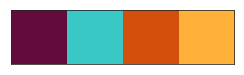

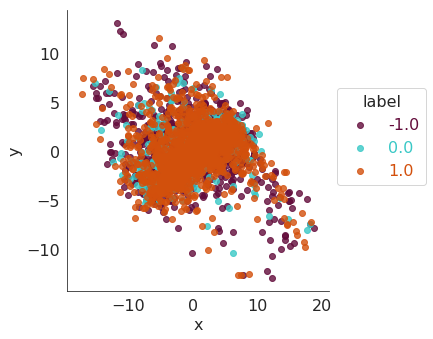

In [213]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#set font size of labels on matplotlib plots
plt.rc('font', size=16)

# Get current size
fig_size = plt.rcParams["figure.figsize"]
# Prints: [8.0, 6.0]
print("Current size:", fig_size)
 # Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
plt.gcf().set_size_inches(15, 9.3, forward=True) 

#set style of plots/

sns.set_style('white')

#define a custom palette
customPalette = ['#630C3B', '#39C8C6', '#D3500C', '#FFB139']
sns.set_palette(customPalette)
sns.palplot(customPalette)

pca = PCA(n_components=2)
X_ = total[all_features_with_momentum]
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = StandardScaler()
X_ = scaler.fit_transform(X_)
data_features_transformed = pca.fit_transform(X_)
features_to_plot = data_features_transformed[:, :2]

#plot data with seaborn (don't add a legend yet)
plot_df = pd.DataFrame(data_features_transformed[:, :2], columns = ['x', 'y'])

#plot_df['x'] = df_visualise["ret_10"]
# plot_df['y'] = total['target_class']

plot_df["label"] = total['target_class']
facet = sns.lmplot(data=plot_df, x='x', y='y', hue='label', 
                   fit_reg=False, legend=False)

#add a legend
leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)
#change colors of labels
for i, text in enumerate(leg.get_texts()):
    plt.setp(text, color = customPalette[i])

In [218]:
pca.explained_variance_ratio_

array([0.24890796, 0.08307088])